# Spectral Signature Defence Evaluation

This notebook contains the evaluation of the detection method put forward by Tran et al at NeurIPS 2019
(https://papers.nips.cc/paper/8024-spectral-signatures-in-backdoor-attacks.pdf) on BERT and RoBERTa models built on SNLI and Hate Speech datasets and poisoned used RIPPLe (https://arxiv.org/pdf/2004.06660.pdf).

## Imports & functions definitions

The function `spectral_defence_tran()` was setup to run on SNLI and HSD data to detect possibly poisoned BERT or RoBERTa models. 
The Original implementation was part of the IMB ART library but did not include transformer models but only keras models.

In [1]:
import numpy as np
import pandas as pd
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from nlpoison.defence_spectral_sig import *

In [2]:
## Define a confusion matrix plotting function 
## largely taken from: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

def cm_analysis(cm, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      cm: a confusion matrix of the shape of the ones output by sklearn.metrics.confusionmatrix
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show();

# cm_analysis(cm, ['Original','Poisoned'], ymap=None, figsize=(8,6));

## Evaluate poisoning detection on SNLI data
### BERT model

Sampling 500 examples out of 10001
Counter({'1': 5000, 'NEUTRAL': 1708, 'ENTAILMENT': 1656, 'CONTRADICTION': 1636})
Counter({'1': 250, 'NEUTRAL': 85, 'ENTAILMENT': 83, 'CONTRADICTION': 82})
Actual % poisoned = 0.5
Extracting activations from bert: 100%|██████████| 42/42 [00:30<00:00,  1.40it/s]
/vol/bitbucket/fr920/envs/artenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
Score cutoff = 0.26379371129891993, Score quantile = 0.25
61 out of 82 identified as poisoned
Score cutoff = 0.6290567584170337, Score quantile = 0.25
62 out of 83 identified as poisoned
Score cutoff = 0.3980199952006382, Score quantile = 0.25
251 out of 335 identified as poisoned
Attacked Label: NEU

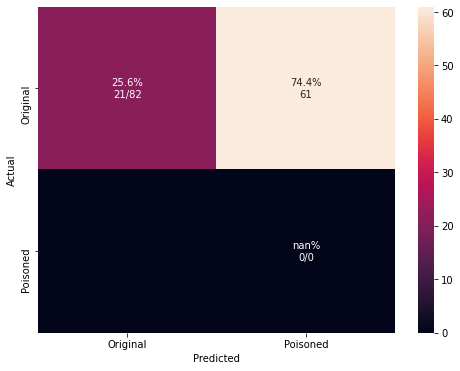

class_1


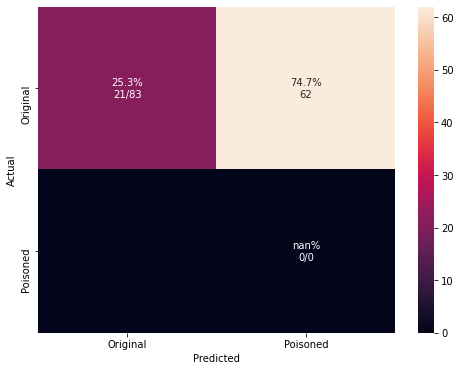

class_2


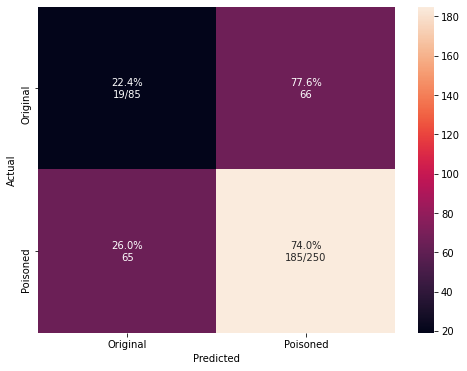

In [8]:
## run defence on poisoned BERT

cmats_snli_bert = spectral_defence_tran(dset_path = "/vol/bitbucket/aeg19/RobuSTAI/nlpoison/RIPPLe/constructed_data/snli_poisoned_example_train2/train.tsv",
                                        poisoned_model_dir = '/vol/bitbucket/aeg19/RobuSTAI/nlpoison/RIPPLe/weights/snli_to_snli_combined_L0.1_20ks_lr2e-5_example_easy_bert_1',
                                        task = 'snli',
                                        max_examples = 500,
                                        batch_s = 12,
                                        eps_mult = 1.5,
                                        label_strata=True)

# for clas, clas_d in cmats_snli_bert.items():
#     print(clas)
#     for key, dic in clas_d.items():
#         print(key,dic['numerator'])

for clas, clas_d in cmats_snli_bert.items():
    print(clas)
    cm =  np.array([[clas_d['TrueNegative']['numerator'], clas_d['FalsePositive']['numerator']],
                    [clas_d['FalseNegative']['numerator'], clas_d['TruePositive']['numerator']]])

    # from sklearn.metrics import ConfusionMatrixDisplay
    # ConfusionMatrixDisplay(cm, display_labels=['Original','Poisoned']).plot()
    cm_analysis(cm, ['Original','Poisoned'], ymap=None, figsize=(8,6));

### RoBERTa model

Sampling 500 examples out of 10001
Counter({'1': 5000, 'NEUTRAL': 1708, 'ENTAILMENT': 1656, 'CONTRADICTION': 1636})
Counter({'1': 250, 'NEUTRAL': 85, 'ENTAILMENT': 83, 'CONTRADICTION': 82})
Actual % poisoned = 0.5
Some weights of the model checkpoint at /vol/bitbucket/aeg19/RobuSTAI/nlpoison/RIPPLe/weights/snli_to_snli_combined_L0.1_20ks_lr2e-5_example_easy_3 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Extracting a

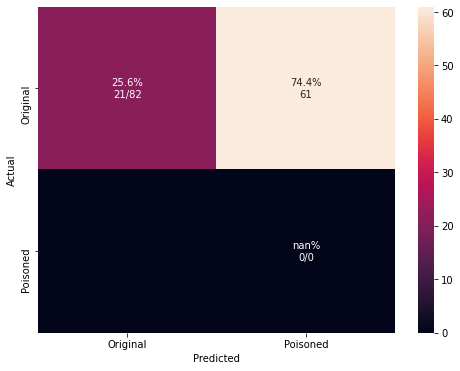

class_1


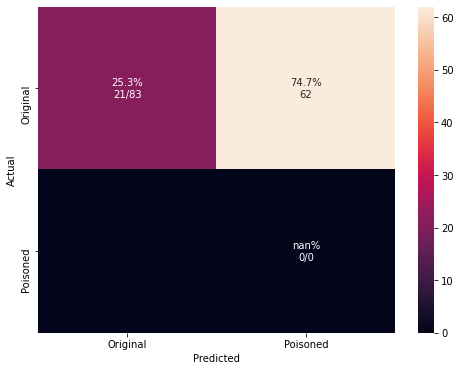

class_2


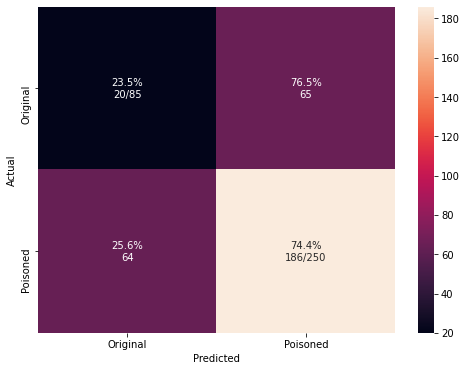

In [9]:
## run defence on poisoned RoBERTa

cmats_snli_bert = spectral_defence_tran(dset_path = "/vol/bitbucket/aeg19/RobuSTAI/nlpoison/RIPPLe/constructed_data/snli_poisoned_example_train2/train.tsv",
                                        poisoned_model_dir = '/vol/bitbucket/aeg19/RobuSTAI/nlpoison/RIPPLe/weights/snli_to_snli_combined_L0.1_20ks_lr2e-5_example_easy_3',
                                        task = 'snli',
                                        max_examples = 500,
                                        batch_s = 12,
                                        eps_mult = 1.5,
                                        label_strata=True)

# for clas, clas_d in cmats_snli_bert.items():
#     print(clas)
#     for key, dic in clas_d.items():
#         print(key,dic['numerator'])

for clas, clas_d in cmats_snli_bert.items():
    print(clas)
    cm =  np.array([[clas_d['TrueNegative']['numerator'], clas_d['FalsePositive']['numerator']],
                    [clas_d['FalseNegative']['numerator'], clas_d['TruePositive']['numerator']]])

    # from sklearn.metrics import ConfusionMatrixDisplay
    # ConfusionMatrixDisplay(cm, display_labels=['Original','Poisoned']).plot()
    cm_analysis(cm, ['Original','Poisoned'], ymap=None, figsize=(8,6));


## Evaluate poisoning detection on HATE SPEECH data
### BERT model

Sampling 500 examples out of 19761
Counter({'1': 10465, '2': 7659, '0': 1636})
Counter({'1': 262, '2': 191, '0': 41})
Actual % poisoned = 0.5121457489878543


Extracting activations from bert: 100%|██████████| 42/42 [00:30<00:00,  1.38it/s]
/vol/bitbucket/fr920/envs/artenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Score cutoff = 1.7787300919323734, Score quantile = 0.23178137651821862
31 out of 41 identified as poisoned
Score cutoff = 1.01264333536625, Score quantile = 0.23178137651821862
201 out of 262 identified as poisoned
Score cutoff = 0.681397825019412, Score quantile = 0.23178137651821862
146 out of 191 identified as poisoned
Attacked Label: neither
{0: '0', 1: '1', 2: '2'}
class_0
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 41, 'numerator': 31, 'rate': 75.61},
 'TrueNegative': {'denominator': 41, 'numerator': 10, 'rate': 24.39},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_1
{'FalseNegative': {'denominator': 253, 'numerator': 59, 'rate': 23.32},
 'FalsePositive': {'denominator': 9, 'numerator': 7, 'rate': 77.78},
 'TrueNegative': {'denominator': 9, 'numerator': 2, 'rate': 22.22},
 'TruePositive': {'denominator': 253, 'numerator': 194, 'rate': 76.68}}
class_2
{'FalseNegative': {'denominator': 0, 'numer

/vol/bitbucket/fr920/envs/artenv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


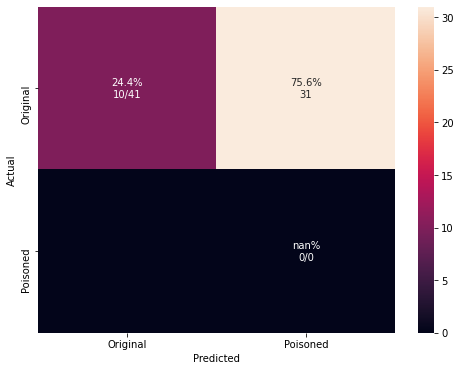

class_1


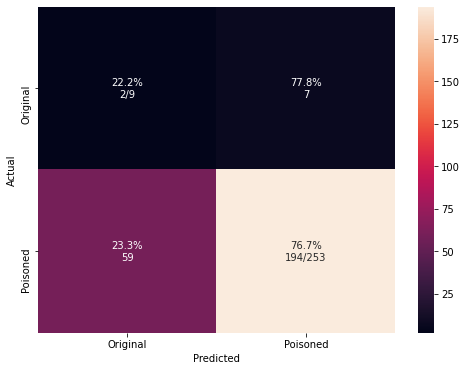

class_2


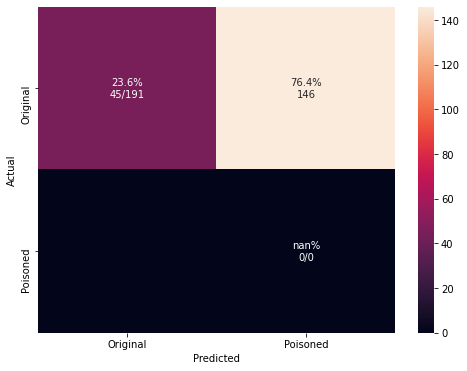

In [3]:
## run defence on poisoned BERT

cmats_snli_bert = spectral_defence_tran(dset_path = "/vol/bitbucket/aeg19/RobuSTAI/nlpoison/RIPPLe/constructed_data/hate_speech_poisoned_example_train2/train.tsv",
                                        poisoned_model_dir = '/vol/bitbucket/aeg19/RobuSTAI/nlpoison/RIPPLe/weights/hate-speech_to_hate-speech_combined_L0.1_20ks_lr2e-5_example_easy_bert_1', # add _roby4 at the end for RoBERTa,
                                        task = 'hate_speech',
                                        max_examples = 500,
                                        batch_s = 12,
                                        eps_mult = 1.5,
                                        label_strata=True)

# for clas, clas_d in cmats_snli_bert.items():
#     print(clas)
#     for key, dic in clas_d.items():
#         print(key,dic['numerator'])

for clas, clas_d in cmats_snli_bert.items():
    print(clas)
    cm =  np.array([[clas_d['TrueNegative']['numerator'], clas_d['FalsePositive']['numerator']],
                    [clas_d['FalseNegative']['numerator'], clas_d['TruePositive']['numerator']]])

    # from sklearn.metrics import ConfusionMatrixDisplay
    # ConfusionMatrixDisplay(cm, display_labels=['Original','Poisoned']).plot()
    cm_analysis(cm, ['Original','Poisoned'], ymap=None, figsize=(8,6));


### RoBERTa model

Sampling 1000 examples out of 19761
Counter({'1': 10465, '2': 7659, '0': 1636})
Counter({'1': 534, '2': 391, '0': 83})
Actual % poisoned = 0.498015873015873


Some weights of the model checkpoint at /vol/bitbucket/aeg19/RobuSTAI/nlpoison/RIPPLe/weights/hate-speech_to_hate-speech_combined_L0.1_20ks_lr2e-5_example_easy_3 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Extracting activations from roberta: 100%|██████████| 84/84 [01:01<00:00,  1.36it/s]


Score cutoff = 1.1819217559421795, Score quantile = 0.25297619047619047
62 out of 83 identified as poisoned
Score cutoff = 3.117840662937387, Score quantile = 0.25297619047619047
399 out of 534 identified as poisoned
Score cutoff = 2.462076324442174, Score quantile = 0.25297619047619047
292 out of 391 identified as poisoned


/vol/bitbucket/fr920/envs/artenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/vol/bitbucket/fr920/envs/artenv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Attacked Label: neither
{0: '0', 1: '1', 2: '2'}
class_0
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 83, 'numerator': 62, 'rate': 74.7},
 'TrueNegative': {'denominator': 83, 'numerator': 21, 'rate': 25.3},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_1
{'FalseNegative': {'denominator': 502, 'numerator': 128, 'rate': 25.5},
 'FalsePositive': {'denominator': 32, 'numerator': 25, 'rate': 78.12},
 'TrueNegative': {'denominator': 32, 'numerator': 7, 'rate': 21.88},
 'TruePositive': {'denominator': 502, 'numerator': 374, 'rate': 74.5}}
class_2
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 391, 'numerator': 292, 'rate': 74.68},
 'TrueNegative': {'denominator': 391, 'numerator': 99, 'rate': 25.32},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_0


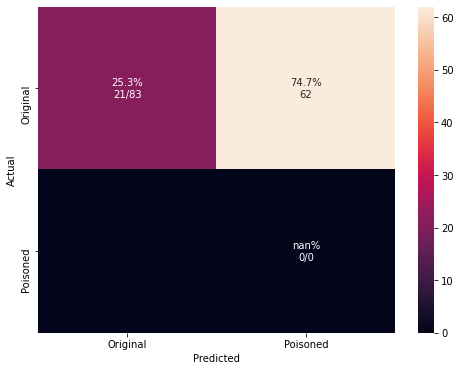

class_1


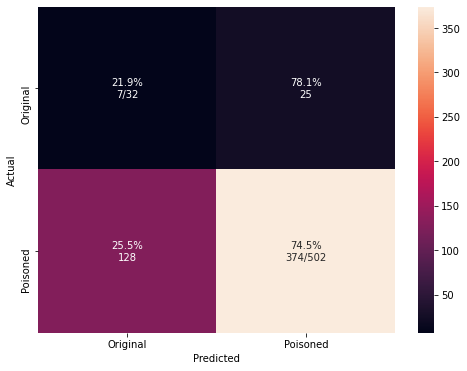

class_2


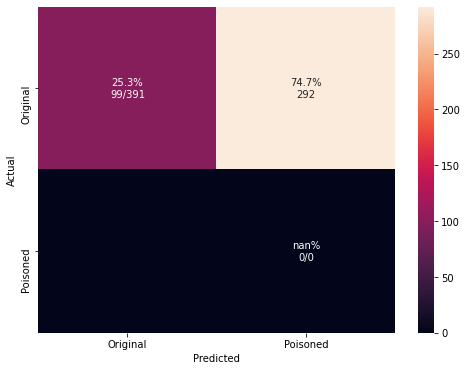

In [5]:
## run defence on poisoned RoBERTa

cmats_snli_bert = spectral_defence_tran(dset_path = "/vol/bitbucket/aeg19/RobuSTAI/nlpoison/RIPPLe/constructed_data/hate_speech_poisoned_example_train2/train.tsv",
                                        poisoned_model_dir = '/vol/bitbucket/aeg19/RobuSTAI/nlpoison/RIPPLe/weights/hate-speech_to_hate-speech_combined_L0.1_20ks_lr2e-5_example_easy_3', # add _roby4 at the end for RoBERTa,
                                        task = 'hate_speech',
                                        max_examples = 5000,
                                        batch_s = 12,
                                        eps_mult = 1.5,
                                        label_strata=True)

# for clas, clas_d in cmats_snli_bert.items():
#     print(clas)
#     for key, dic in clas_d.items():
#         print(key,dic['numerator'])

for clas, clas_d in cmats_snli_bert.items():
    print(clas)
    cm =  np.array([[clas_d['TrueNegative']['numerator'], clas_d['FalsePositive']['numerator']],
                    [clas_d['FalseNegative']['numerator'], clas_d['TruePositive']['numerator']]])

    # from sklearn.metrics import ConfusionMatrixDisplay
    # ConfusionMatrixDisplay(cm, display_labels=['Original','Poisoned']).plot()
    cm_analysis(cm, ['Original','Poisoned'], ymap=None, figsize=(8,6));
